<a href="https://colab.research.google.com/github/nathanhawe/CSCI-264/blob/main/ToH_QLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Q Learning

Import necessary packages and set some default values used throughout the rest of the program:

**REWARD_GOAL** => *The reward given when the agent reaches the goal state*

**REWARD_TRANSITION** => *The reward given when the agent sucessfully transitions to *a non-goal state.

**REWARD_FAIL** => *The rewards given when the agent attempts to transition to an invalid state (or attempts to stay its current state).*

**MAX_POLICY_STEPS** => *The maximum number of policy steps to attempt when evaluating policies.*

**SAME_POLICY_COUNT_CONVERGENCE_VALUE** => *The number of successive identical complete policy evaluation values necessary to consider the algorithm converged on the optimal policy.*

**test_range** => *The specific sizes of n to test both the Q-Learning and Iterative Deepning Search algorithms on.

**test_batch_size** => *The number of times to run each algorithm to calculate average run time*



In [226]:
import numpy as np
from tabulate import tabulate # (https://pypi.org/project/tabulate/)
import matplotlib.pyplot as plt
import time

# Set some default values
REWARD_GOAL = 100
REWARD_TRANSITION = -.01
REWARD_FAIL = -1
MAX_POLICY_STEPS = 1000
SAME_POLICY_COUNT_CONVERGENCE_VALUE = 20
test_range = range(1, 6)
test_batch_size = 100

# Initialize random number generator for repeatability
RNG = np.random.default_rng(42)

These functions translate integer values into strings or arrays that represent the current position of each of the n disk pieces.  For example, for a game with 3 pieces, the array [0,0,0] indicates that all three disks are on the first peg.  The array [0,0,2] indicates that the large and medium disks are on the first peg and the smallest disk is on the third peg.

In [ ]:
# Takes the the number of pieces (n) in the game and an integer value (x),
# returns an array of the base n representation of x.
def translate_to_array(n, x):
  res = []
  for i in range(n-1, -1, -1):
    xx = x // 3**i
    x = x % 3**i
    res.append(xx)
  return res

# Takes the the number of pieces (n) in the game and an integer value (x),
# returns a string of the base n representation of x.
def translate_to_string(n, x):
  return ''.join([str(s) for s in translate_to_array(n, x)])

print(translate_to_array(3, 0))
print(translate_to_array(3, 2))
print(translate_to_array(3, 26))

print(translate_to_string(3, 0))
print(translate_to_string(3, 2))
print(translate_to_string(3, 26))


[0, 0, 0]
[0, 0, 2]
[2, 2, 2]
000
002
222


Functions to help with plotting graphs.

In [237]:
def print_experiment(episodes):
  x_val = [ e['episode'] for e in episodes]
  y_val = [ e['policy_value'] for e in episodes]

  plt.plot(x_val, y_val)
  plt.xlabel("Episode #")
  plt.ylabel("Solution Length")
  plt.title("Single Episode Optimal Policy Convergence")
  plt.show()

def print_batch(batch):
  for i in range(len(batch)):
    x_val = [ e['episode'] for e in batch[i]['episodes']]
    y_val = [ e['policy_value'] for e in batch[i]['episodes']]
    plt.plot(x_val, y_val, label = str(i))

  plt.xlabel("Episode #")
  plt.ylabel("Solution Length")
  plt.title("Multiple Episode Optimal Policy Convergence")
  plt.show()

def print_average_times(times, title):
  x_val = [ t['n'] for t in times]
  y_val = [ t['avg_seconds'] for t in times]

  plt.plot(x_val, y_val)
  plt.xlabel("Number of Disks (n)")
  plt.ylabel("Average Seconds")
  plt.title(title)
  plt.show()

def print_average_solution_length(times, title):
  x_val = [ t['n'] for t in times]
  y_val = [ t['avg_solution_length'] for t in times]

  plt.bar(x_val, y_val)
  plt.xticks(x_val)
  plt.xlabel("Number of Disks (n)")
  plt.ylabel("Solution Length")
  plt.title(title)
  plt.show()

This function returns true if the action to move from state s1 to state s2 is valid.  Validity is determined by a number of rules:

1.   The agent cannot choose to stay in the same state.
1.   The agent cannot move more than one piece at a time.
1.   The agent cannot move a piece that is under another piece.
1.   The agent cannot move a piece on top of a smaller piece.

In [ ]:
def is_valid_action(n, s1, s2):
  if s1 == s2:
    return False

  if s1 == 3**n-1:
    return False

  s1_f = translate_to_array(n, s1)
  s2_f = translate_to_array(n, s2)

  # More than one piece changed positions
  index_of_change = -1
  for i in range(n):
    if s1_f[i] != s2_f[i]:
      if index_of_change != -1:
        return False
      else:
        index_of_change = i

  # The piece moved is under another piece
  for i in range(index_of_change + 1, n):
    if(s1_f[index_of_change] == s1_f[i]):
      return False

  # The piece moved is moving to a spot occupied by a smaller piece
  for i in range(index_of_change + 1, n):
    if(s2_f[index_of_change] == s1_f[i]):
      return False
  return True


print(f"Move from {translate_to_string(3, 7)} to {translate_to_string(3, 8)}: {is_valid_action(3, 7, 8)}")
print(f"Move from {translate_to_string(3, 5)} to {translate_to_string(3, 8)}: {is_valid_action(3, 5, 8)}")


Move from 021 to 022: True
Move from 012 to 022: False


The intialize function create a new Q values table setting the intial state for all values to 0 except for the actions that result in a goal state.

In [ ]:
def initialize_qtable(n):
  # The size of a 2D q-values table will be 3^n x 3^n
  qt = np.zeros((3**n,3**n))
  for i in range(len(qt)):
    j = len(qt[i]) - 1
    qt[i][j] = REWARD_GOAL if is_valid_action(n, i, j) else 0
  return qt

# Helper function to layout q values table
def print_qtable(n, t):
  col_labels = [translate_to_string(n, i) for i in range(3**n)]
  row_labels = col_labels
  print(tabulate(t, headers=col_labels, showindex=row_labels))

print_qtable(2, initialize_qtable(2))

      00    01    02    10    11    12    20    21    22
--  ----  ----  ----  ----  ----  ----  ----  ----  ----
00     0     0     0     0     0     0     0     0     0
01     0     0     0     0     0     0     0     0     0
02     0     0     0     0     0     0     0     0     0
10     0     0     0     0     0     0     0     0     0
11     0     0     0     0     0     0     0     0     0
12     0     0     0     0     0     0     0     0     0
20     0     0     0     0     0     0     0     0   100
21     0     0     0     0     0     0     0     0   100
22     0     0     0     0     0     0     0     0     0


The transition function returns the reward, next state, and completion flag when moving from state s1 to s2.  The completion flag is used to identify when the goal state is reached.

In [ ]:
# Returns the reward, next state, and completion flag for taking the action from s1 to s2
def reward_next_state_for_action(n, s1, s2):
  if is_valid_action(n, s1, s2):
    if s2 == 3**n-1:
      return (REWARD_GOAL, s2, True)
    else:
      return (REWARD_TRANSITION, s2, False)
  return (REWARD_FAIL, s1, False)

print(reward_next_state_for_action(2, 0, 1)) # Regular transition
print(reward_next_state_for_action(2, 5, 8)) # Failed transition
print(reward_next_state_for_action(2, 7, 8)) # Transition to goal state


(-0.01, 1, False)
(-1, 5, False)
(100, 8, True)


The following functions are used to identify the best action to take from a specific state and for policy evaluation.  In this program, policies are evaluated based on the length of the resulting solution.  This allows the learning to be stopped before values converge as we know that the optimal solution for towers of hanoi is 2^n - 1 where n is the number of disks.

In [ ]:
# Returns the best action to take based on the provided q table and starting state.
# The lowest index is returned as a tie breaker.
def best_action_for_state(qt, s1):
  return np.argmax(qt[s1])

# Generate a new greedy policy for the q table provided
def create_policy(qt):
  policy = []
  for i in range(len(qt)):
    policy.append(best_action_for_state(qt, i))
  return policy

# Evaluates the policy by counting the number of steps from starting state s1
# to goal state s2.  Returns a tuple indicating the count of steps and whether
# the evaluation completed by the max_steps value.
def evaluate_policy(policy, s1, s2, max_steps = MAX_POLICY_STEPS):
  current_state = s1
  count = 0
  while current_state != s2:
    if count == max_steps:
      return (count, False)
    current_state = policy[current_state]
    count += 1
  return (count, True)

def print_policy(n, policy):
  policy = [translate_to_string(n, x) for x in policy]
  policy = np.reshape(policy, (3**n,1))
  print(tabulate(policy, headers=["Action"], showindex = [translate_to_string(n,i) for i in range(3**n)]))


A single experiment is conducted by initializing a q values table and running episodes until the policy values converge.  Each episode runs until the goal state is reached from the starting state.  The use of epsilon-greedy action selection ensures that each episode will eventually complete.  

In [ ]:
def execute_experiment(n, gamma, alpha, epsilon):
  # Start with a new initialized q table
  qt = initialize_qtable(n)

  episodes = []
  episode_count = 0
  previous_policy_value = 0
  same_policy_count = 0
  while True:
    episode_count += 1

    # Run a single episode starting from 0
    step_count = 0
    current_state = 0
    while True:
      step_count += 1

      # Select the next action using epsilon-greedy on Q values
      if RNG.random() < epsilon:
        action = RNG.integers(low = 0, high = 3**n)
      else:
        action = best_action_for_state(qt, current_state)

      # Get the reward and transition state for the selected action
      (reward, next_state, is_complete) = reward_next_state_for_action(n, current_state, action)

      # Calculate the error and update the q-values
      error = (reward + gamma * qt[next_state][best_action_for_state(qt, next_state)] - qt[current_state][action])
      qt[current_state][action] += alpha * error

      # Advance to the next state
      current_state = next_state

      if is_complete:
        break

    # Create and evaluate a policy based on the q table after episode completion
    policy = create_policy(qt)
    (policy_value, policy_complete) = evaluate_policy(policy, 0, 3**n - 1)

    if policy_complete:
      same_policy_count = same_policy_count + 1 if policy_value == previous_policy_value else 0
    else:
      same_policy_count = 0

    previous_policy_value = policy_value

    # print(f"Completed Episode {episode_count} in {step_count} steps with a policy solution length: {policy_value}{'' if policy_complete else '+'}.  Policy consistency: {same_policy_count}")
    episodes.append({
        'episode': episode_count,
        'steps': step_count,
        'policy_value': policy_value
    })

    if same_policy_count >= SAME_POLICY_COUNT_CONVERGENCE_VALUE:
      return episodes, policy
      break


A single experiment can be run by providing the n, gamma, alpha, and epsilon values.

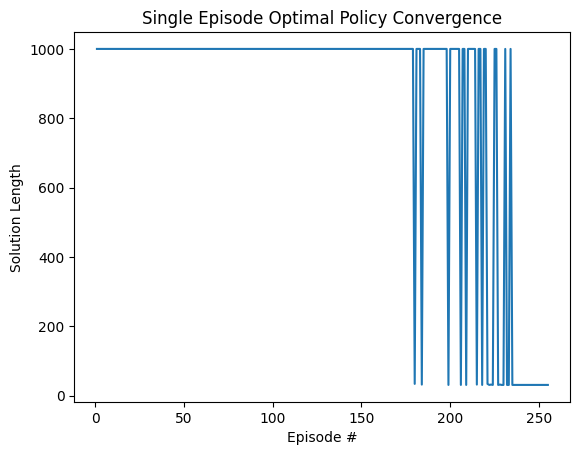

Final Policy:
         Action
-----  --------
00000     00002
00001     00002
00002     00012
00010     00011
00011     00211
00012     00011
00020     00022
00021     00022
00022     00122
00100     00200
00101     00102
00102     00101
00110     00111
00111     02111
00112     00110
00120     00122
00121     00120
00122     00120
00200     00100
00201     00221
00202     00200
00210     00220
00211     00210
00212     00210
00220     00222
00221     00222
00222     01222
01000     01002
01001     01021
01002     01012
01010     01012
01011     01010
01012     01011
01020     01010
01021     01022
01022     01122
01100     01102
01101     01102
01102     01112
01110     01111
01111     21111
01112     01111
01120     01110
01121     01101
01122     01120
01200     01100
01201     01200
01202     01200
01210     01211
01211     01011
01212     01211
01220     01222
01221     01201
01222     01221
02000     02002
02001     02002
02002     02001
02010     02020
02011     02010
02012     

In [218]:
n = 5
gamma = 0.9
alpha = 0.1
epsilon = 0.01

episodes, final_policy = execute_experiment(n, gamma, alpha, epsilon)
print_experiment(episodes)
print("Final Policy:")
print_policy(n, final_policy)


A batch of episodes can be executed to average performance.

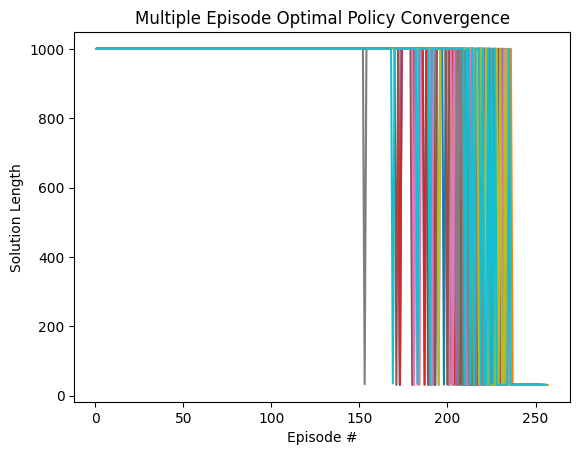

In [245]:
def execute_batch(batch_size, n, gamma, alpha, epsilon):
  batch = []
  for i in range(batch_size):
    start_time = time.process_time()
    episodes, final_policy = execute_experiment(n, gamma, alpha, epsilon)
    duration = time.process_time() - start_time
    batch.append({
        'experiment': i+1,
        'episode_count': len(episodes),
        'final_policy_value': episodes[-1]['policy_value'],
        'seconds':duration,
        'episodes': episodes
    })
  return batch

n = 5
gamma = 0.9
alpha = 0.1
epsilon = 0.01
batch_size = 20

batch = execute_batch(batch_size, n, gamma, alpha, epsilon)
print_batch(batch)

Compare the average time to converge on the optimal solution for different numbers of pieces n.

In [217]:
q_learning_times = []

for n in test_range:
  batch = execute_batch(test_batch_size, n, gamma, alpha, epsilon)
  q_learning_times.append({
      'n': n,
      'avg_seconds': np.mean([b['seconds'] for b in batch]),
      'avg_solution_length': np.mean([b['final_policy_value'] for b in batch])
  })

print_average_times(q_learning_times, "Average Learning Time by Number of Disks (Q-Learning)")
print_average_solution_length(q_learning_times, "Solution Length by Number of Disks (Q-Learning)")


KeyboardInterrupt: 

# Iterative Deepening Search

Generate an adjacency matrix using the `is_valid_action(n, s1, s2)` function defined for the Q Learning section.

In [221]:
def create_adjacency_matrix(n):
  adjacency_list = np.zeros((3**n, 3**n))
  for i in range(len(adjacency_list)):
    for j in range(len(adjacency_list[i])):
      adjacency_list[i,j] = 1 if is_valid_action(n, i, j) else 0
  return adjacency_list

n = 2

print_qtable(n, create_adjacency_matrix(n))

      00    01    02    10    11    12    20    21    22
--  ----  ----  ----  ----  ----  ----  ----  ----  ----
00     0     1     1     0     0     0     0     0     0
01     1     0     1     0     0     0     0     1     0
02     1     1     0     0     0     1     0     0     0
10     0     0     0     0     1     1     1     0     0
11     0     0     0     1     0     1     0     0     0
12     0     0     1     1     1     0     0     0     0
20     0     0     0     1     0     0     0     1     1
21     0     1     0     0     0     0     1     0     1
22     0     0     0     0     0     0     0     0     0


This recursive implementation of the iterative deepening search algorithm will search the provided graph (adjacency matrix) for `goal_state` starting from `start_state`.  It returns an array representing the path from the start state to the goal state or `None` if no such path is found.

In [223]:
def iterative_deepening_search(adj_matrix, start_state, goal_state):
  depth = 0
  is_cutoff = True
  is_fail = False

  while is_cutoff and not is_fail:
    is_cutoff, is_fail, node = depth_limited_search(set(), adj_matrix, start_state, goal_state, depth)
    depth += 1

  if is_fail:
    return None

  # Convert the node object into an array of steps
  result_arr = []
  while node is not None:
    result_arr.append(node['state'])
    node = node['parent']
  return [result_arr[i-1] for i in range(len(result_arr), 0, -1)]


def depth_limited_search(visited, adj_matrix, start_state, goal_state, limit):
  visited.add(start_state)
  return recursive_dls(visited, adj_matrix, {'state': start_state, 'parent':None, 'depth': 0}, goal_state, limit)

def recursive_dls(visited, adj_matrix, node, goal_state, limit):
  cutoff_occurred = False

  if node['state'] == goal_state:
    return (False, False, node)

  if node['depth'] == limit:
     return (True, False, None)

  for successor in expand(visited, adj_matrix, node):
    (is_cutoff, is_failure, result_node) = recursive_dls(visited, adj_matrix, successor, goal_state, limit)
    if is_cutoff:
      cutoff_occurred = True
    elif not is_failure:
      return (False, False, result_node)

  if cutoff_occurred:
    return (True, False, None)

  return (False, True, None)


def expand(visited, adj_matrix, node):
  s = node['state']
  d = node['depth'] + 1

  neighbors = []
  for i in range(len(adj_matrix[s])):
    if i not in visited and adj_matrix[s][i] == 1:
      neighbors.append({
          'state': i,
          'parent': node,
          'depth': d
      })
      visited.add(i)
  return neighbors

# This will return a path because 8 is a state in the graph
print(iterative_deepening_search(create_adjacency_matrix(2),0, 8))

# This will not return a path because 9 is not a state in the graph
print(iterative_deepening_search(create_adjacency_matrix(2),0, 9))


[0, 1, 7, 8]
None


The `translate_to_array(n, x)` and `translate_to_string(n, x)` functions defined in Q learning can be used to format the solution returned from iterative deepening search.

In [224]:
result = iterative_deepening_search(create_adjacency_matrix(2),0, 8)
print([translate_to_array(n, x) for x in result])
print([translate_to_string(n, x) for x in result])


[[0, 0], [0, 1], [2, 1], [2, 2]]
['00', '01', '21', '22']


Perform IDS for the same sizes as Q Learning while measuring the average completion time for the same number of executions as Q Learning.

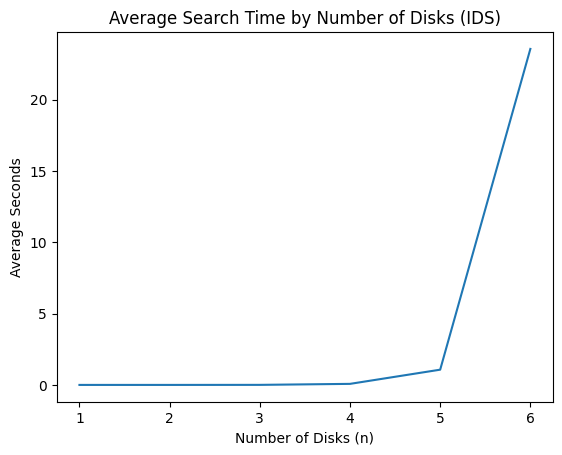

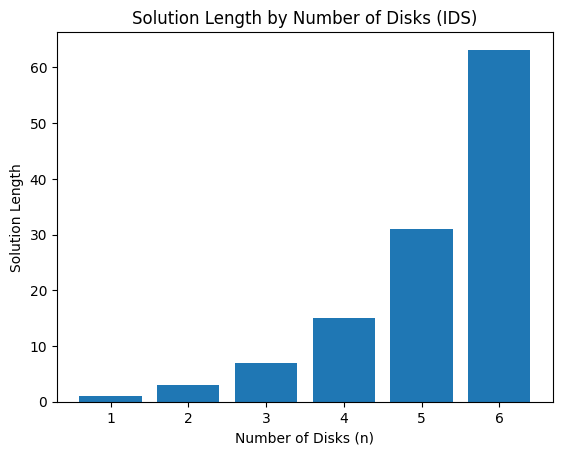

In [225]:
def measure_ids(batch_size, n):
  batch = []
  for i in range(batch_size):
    start = time.process_time()
    result = iterative_deepening_search(create_adjacency_matrix(n),0, 3**n - 1)
    duration = time.process_time() - start
    batch.append(duration)
  return {'solution': result, 'avg_seconds': np.mean(batch)}

ids_evaluation = []
for n in test_range:
  result = measure_ids(test_batch_size, n)
  ids_evaluation.append({
      'n': n,
      'avg_seconds': result['avg_seconds'],
      'solution': result['solution'],
      'avg_solution_length': len(result['solution'])
  })

print_average_times(ids_evaluation, "Average Search Time by Number of Disks (IDS)")
print_average_solution_length(q_learning_times, "Solution Length by Number of Disks (IDS)")

# Contrasting Execution Time

Comparing the execution time between both algorithms.

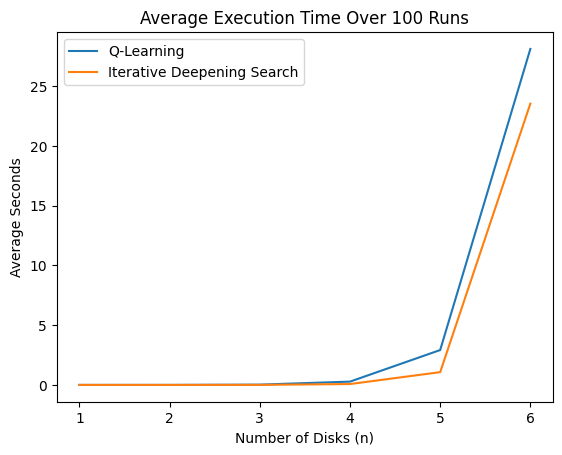

In [227]:
q_x_val = [ t['n'] for t in q_learning_times]
q_y_val = [ t['avg_seconds'] for t in q_learning_times]
ids_x_val = [ t['n'] for t in ids_evaluation]
ids_y_val = [ t['avg_seconds'] for t in ids_evaluation]

plt.plot(q_x_val, q_y_val, label="Q-Learning")
plt.plot(ids_x_val, ids_y_val, label="Iterative Deepening Search")
plt.xlabel("Number of Disks (n)")
plt.ylabel("Average Seconds")
plt.xticks(q_x_val)
plt.title(f"Average Execution Time Over {test_batch_size} Runs")
plt.legend()
plt.show()

# print_average_times(q_learning_times, "Average Learning Time by Number of Disks (Q-Learning)")
# print_average_solution_length(q_learning_times, "Solution Length by Number of Disks (Q-Learning)")